# EBGAN (Gaussian Example)
## Data generation

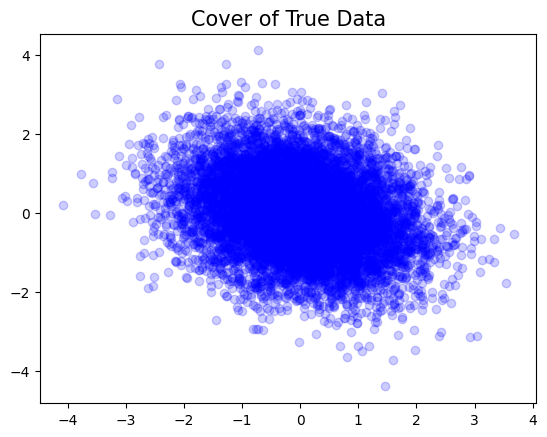

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## Set seed
np.random.seed(1233)
torch.manual_seed(1233)

## Data generation

x_dim = 2
N = 10000
true_z_dim = 2

### generate synthetic data

Xs = []
for _ in range(1):
    cluster_mean = np.random.randn(true_z_dim) * 1# to make them more spread
    A = np.random.randn(x_dim,true_z_dim) * 1
    X = np.dot(np.random.randn(int(N / 1), true_z_dim)*1 + cluster_mean, A.T)
    Xs.append(X)
X_raw = np.concatenate(Xs)
X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))

X=torch.from_numpy(X).float()

### visualization of the true data

import matplotlib
x = X[:, 0]
y = X[:, 1]
matplotlib.pyplot.scatter(x, y,color='blue', alpha=0.2)
matplotlib.pyplot.title("Cover of True Data",fontsize=15)
matplotlib.pyplot.show()

## Train EBGAN
### KL prior

In [ ]:
## For KL prior: Code reference(https://github.com/nhartland/KL-divergence-estimators)

def knn_distance(point, sample, k):
    """ Euclidean distance from `point` to it's `k`-Nearest
    Neighbour in `sample` """
    norms = torch.linalg.norm(sample-point, axis=1)
    return torch.sort(norms)[0][k]


def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert(len(s1.shape) == len(s2.shape) == 2)
    # Check dimensionality of sample is identical
    assert(s1.shape[1] == s2.shape[1])


def naive_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using brute-force (numpy) k-NN
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    D = np.log(m / (n - 1))
    d = float(s1.shape[1])

    for p1 in s1:
        nu = knn_distance(p1, s2, k-1)  # -1 because 'p1' is not in 's2'
        rho = knn_distance(p1, s1, k)
        D += (d/n)*torch.log(nu/rho)
    return D

##############################


## Train by KL prior

In [ ]:
### NN structures


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        #self.sig=nn.Sigmoid()

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        #out= self.sig(out)
        return out

### Setting

nz=10
batch_size = 64


J_g=10
J_d=1

# Generator and Discriminator
G=[None]*J_g
D=[None]*J_d

noise_G=[None]*J_g
noise_D=[None]*J_d

G_optimizer=[None]*J_g
D_optimizer=[None]*J_d



init_lr_d=1
lr_g=0.01

for i in range(J_g):
    G[i]=FeedforwardNeuralNetModel(nz,1000, x_dim).cuda()
    G_optimizer[i]=torch.optim.SGD(G[i].parameters(),lr=lr_g)
for i in range(J_d):
    D[i]=FeedforwardNeuralNetModel(x_dim,1000, 1).cuda()
    D_optimizer[i]=torch.optim.SGD(D[i].parameters(),lr=init_lr_d)

n=0
for p in G[0].parameters():
    n=n+1

M=[]
for j in range(J_g):
  M.append([None]*n)

for j in range(J_g):
    n=0
    for par in G[0].parameters():
        M[j][n]=torch.zeros(par.size()).cuda()
        n=n+1


Dis=torch.zeros(251)
Gen=torch.zeros(251)

a=1
beta_1=0.9
mean_sample=128

tau=1
loss_criteria=nn.BCEWithLogitsLoss()
#loss_criteria=nn.BCELoss()

real=torch.ones(batch_size).cuda()
fake=torch.zeros(batch_size).cuda()


js=0
sig=nn.Sigmoid()
perm = torch.randperm(N)
idx=perm[:batch_size]

X_batch=X[idx,].cuda()

fake_data = []
t=0
for iter in range(2501):
    # Train Generator
    for i in range(J_g):
        noise_G[i]=2*torch.rand(batch_size,nz).cuda()-1


    for j in range(J_g):
        G_loss=0

        Gen_Dis=D[0](G[j](noise_G[j])).view(-1)

        G_loss=G_loss+loss_criteria(Gen_Dis,real)

        G_loss+=torch.abs(naive_estimator(X_batch.cpu(),G[j](noise_G[j]).cpu())/N*100)


        G_optimizer[j].zero_grad()

        G_loss.backward()
        G_optimizer[j].step()


        n=0
        for par in G[j].parameters():
            par.data.sub_(a*M[j][n]*lr_g/N)
            n=n+1

        with torch.no_grad():
            for param in G[j].parameters():
                param.add_(torch.randn(param.size()).cuda() * np.sqrt(2*lr_g/N*tau))

        n=0
        for par in G[j].parameters():
            M[j][n]*=beta_1
            M[j][n]+=(1-beta_1)*par.grad.data*N
            n=n+1

    for i in range(J_d):
        noise_D[i]=2*torch.rand(batch_size,nz).cuda()-1

    for j in range(J_d):

        D_loss=0

        lr_d=init_lr_d*(iter+1000)**(-3/4)
        for param_group in D_optimizer[j].param_groups:
          param_group['lr'] = lr_d


        perm = torch.randperm(N)
        idx=perm[:batch_size]

        X_batch=X[idx,].cuda()


        for k in range(J_g):
          D_loss+= loss_criteria(D[j](X_batch).view(batch_size).requires_grad_(),real)+loss_criteria(D[j](G[k](noise_D[0])).view(-1),fake)


        D_loss=D_loss/J_g

        D_optimizer[j].zero_grad()

        D_loss.backward()
        D_optimizer[j].step()


    if (iter+1)%10==1:
      with torch.no_grad():
        perm = torch.randperm(N)
        idx=perm[:mean_sample]
        X_batch=X[idx,].requires_grad_().cuda()
        mean=0
        for i in range(J_g):
          mean+=torch.mean(sig(D[0](G[i](2*torch.rand(mean_sample,nz).cuda()-1)).view(-1)))
        Gen[js]=mean/J_g
        Dis[js]=torch.mean(sig(D[0](X_batch).view(mean_sample)))
        js=js+1

fake_data = []
for num_samples in range(20):
    for g in range(J_g):
        # collect sample
        sample_z = 2*torch.rand(50,nz).cuda()-1
        sampled_data = G[2](sample_z).detach().cpu().numpy()
        fake_data.append(sampled_data)



(-4.0, 4.0)

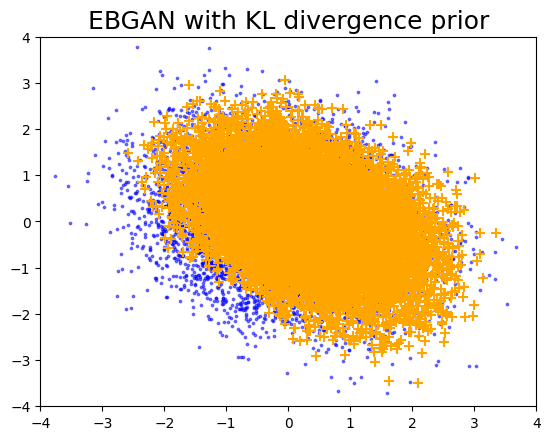

In [ ]:

matplotlib.pyplot.title("EBGAN with KL divergence prior",fontsize=18)
x = X[:, 0]
y = X[:, 1]
matplotlib.pyplot.scatter(x, y,color='blue', alpha=0.5,s=3)
fake_data=np.array(fake_data)
fake_data.resize((50*J_g*20,2),refcheck=False)
x = fake_data[:, 0]
y = fake_data[:, 1]
matplotlib.pyplot.scatter(x, y,color="orange",marker="+",s=50)

matplotlib.pyplot.xlim((-4,4))
matplotlib.pyplot.ylim((-4,4))




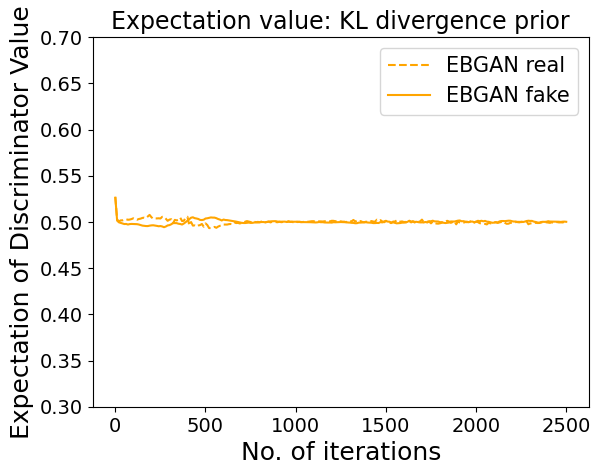

In [ ]:
matplotlib.pyplot.title("Expectation value: KL divergence prior",fontsize=17)
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Dis,label="EBGAN real",color='orange',linestyle='--')
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Gen,label="EBGAN fake",color='orange',linestyle='-')
matplotlib.pyplot.xlabel('No. of iterations',fontsize=18)
matplotlib.pyplot.ylabel('Expectation of Discriminator Value',fontsize=18)
matplotlib.pyplot.ylim((0.3, 0.7))
matplotlib.pyplot.legend(fontsize="15")
matplotlib.pyplot.xticks(fontsize=14)
matplotlib.pyplot.yticks(fontsize=14)
matplotlib.pyplot.show()
